# Detección de Animales Marinos con Deep Learning

## Introducción
En este proyecto, desarrollamos un modelo de clasificación de imágenes para identificar diferentes tipos de animales marinos, como delfines, peces, medusas, tortugas y ballenas. Este tipo de modelo tiene una amplia gama de aplicaciones, desde la investigación científica hasta la conservación de la vida marina mediante monitoreo de especies en peligro y evaluar el impacto de las activdades humana para ellos.

## Solución
Para abordar estos desafíos, utilizamos una arquitectura de red neuronal convolucional (CNN) avanzada, específicamente una variante de ResNet con bloques de Squeeze-and-Excite (SE). Esta arquitectura permite al modelo enfocarse en las características más relevantes de las imágenes, mejorando así la precisión de la clasificación. Además, implementamos técnicas de aumento de datos y ponderación de clases para manejar el desequilibrio en el conjunto de datos y mejorar la robustez del modelo.

## Datos
Fuente: [Kaggle - Sea Animals Image Dataset](https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste)

### Análisis
El dataset contiene imágenes de cinco tipos de animales marinos: delfines (Dolphin), peces (Fish), medusas (Jelly_Fish), tortugas (Turtle_Tortoise) y ballenas (Whale). Las imágenes fueron obtenidas mediante una API para Google Images.

### Separación
El dataset se ha dividido en tres subconjuntos:
- Entrenamiento: 70%
- Validación: 15%
- Prueba: 15%

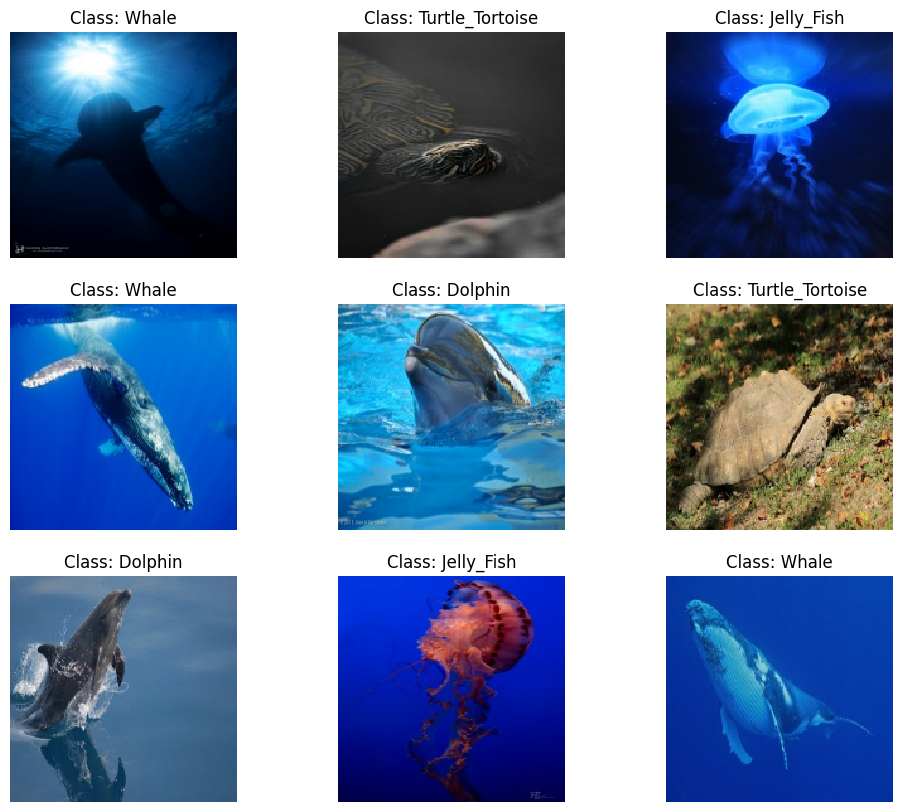

In [57]:
class_names = ['Dolphin', 'Fish', 'Jelly_Fish', 'Turtle_Tortoise', 'Whale']

plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

# Desarrollo del modelo: Arquitectura de la red neuronal
Para resolver el problema de clasificación de animales marinos, hemos diseñado un modelo de red neuronal convolucional (CNN) inspirado en la arquitectura ResNet, una de las arquitecturas más avanzadas en visión por computadora. Este tipo de modelo es altamente efectivo para la extracción de características visuales y permite entrenar redes profundas con gran eficiencia. La base de nuestra arquitectura es una red residual que utiliza bloques de ResidualUnit, diseñados para mejorar el flujo de gradientes a través de conexiones de atajo (skip connections) entre capas.

- `Capa de entrada y aumentos de datos`: El modelo recibe imágenes de tamaño (180, 180, 3), y para aumentar la robustez del modelo frente a variaciones en las imágenes, aplicamos técnicas de data augmentation como rotación aleatoria, volteo horizontal y zoom aleatorio. Estos aumentos ayudan a mejorar la capacidad de generalización del modelo al simular variaciones naturales en las imágenes de entrenamiento.

- `Bloques de convolución iniciales`: La red comienza con una capa convolucional de gran tamaño (7x7) y 64 filtros, seguida de una capa de normalización por lotes (BatchNormalization) y una función de activación ReLU. Luego, una capa de max-pooling reduce la dimensionalidad espacial de las imágenes, conservando la información esencial.

- `Capas residuales`: Utilizamos bloques residuales personalizados (ResidualUnit), que contienen convoluciones separables y capas de normalización por lotes. Estos bloques permiten que la red aprenda representaciones más complejas, manteniendo el flujo de gradientes estable. Los bloques residuales están organizados en cuatro etapas, cada una con una mayor cantidad de filtros (64, 128, 256 y 512) para capturar características visuales en múltiples escalas y niveles. Además, en cada cambio de etapa, se ajusta el tamaño de los filtros mediante strides mayores, lo cual reduce la dimensionalidad de las imágenes.

- `Capa de salida y Dropout`: Al final, el modelo incluye una capa de Global Average Pooling para reducir las características a un vector, seguida de una capa de Dropout (0.5) para evitar el overfit. Finalmente, la salida es una capa densa con activación sigmoide, configurada para clasificación binaria en esta versión del modelo, que se ajustará según las categorías específicas de animales en el conjunto de datos.

Esta arquitectura, que combina una red residual con data augmentation y técnicas de regularización, nos ofrece un balance entre capacidad de aprendizaje y resistencia al overfit, adecuado para la clasificación de imágenes en conjuntos de datos complejos y desbalanceados.

In [31]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

In [32]:
class ResidualUnit(keras.layers.Layer): # Extend base Layer class
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) # Call Layer's init
        self.activation = keras.activations.get(activation) # Get activation layer
        self.main_layers = [
            keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.SeparableConv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: # Resize input if needed
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(180, 180, 3)))

# Data augmentation and scaling
model.add(keras.layers.RandomFlip("horizontal"))
model.add(keras.layers.RandomRotation(0.1))
model.add(keras.layers.RandomZoom(0.2))
model.add(keras.layers.Rescaling(1./255))

# ResNet
model.add(keras.layers.Conv2D(64, 7, strides=2,
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())

# Dropout
model.add(keras.layers.Dropout(0.5))

# Changing the output layer to use with our dataset
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 90, 90, 64)     │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 45, 45, 64)     │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 45, 45, 64)     │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 45, 45, 64)     │         9,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 23, 23, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 23, 23, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 23, 23, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 23, 23, 128)    │        36,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 12, 12, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 12, 12, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 12, 12, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 12, 12, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 12, 12, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 12, 12, 256)    │       137,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 6, 6, 512)      │       537,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 6, 6, 512)      │       537,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 6, 6, 512)      │       537,60

 Total params: 2,623,297 (10.01 MB)

 Trainable params: 2,606,273 (9.94 MB)

 Non-trainable params: 17,024 (66.50 KB)

## Compilar y correr el modelo con el dataset

In [52]:
import os, shutil, pathlib
from keras.utils import image_dataset_from_directory

# Define base directory for the dataset
base_dir = pathlib.Path("ocean_animals")

# Load training, validation, and test datasets
train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),  # Resize the images to 180x180
    batch_size=32)  # Specify batch size

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),  # Resize the images to 180x180
    batch_size=32)  # Specify batch size

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),  # Resize the images to 180x180
    batch_size=32)  # Specify batch size


Found 3215 files belonging to 5 classes.
Found 687 files belonging to 5 classes.
Found 694 files belonging to 5 classes.


In [ ]:
# Changing the output layer to match our dataset's 5 classes
model.add(keras.layers.Dense(5, activation="softmax"))

# Compile the model with sparse categorical crossentropy for multi-class classification
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="resnet_dsc.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=30,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 59s 477ms/step - accuracy: 0.3947 - loss: 1.4788 - val_accuracy: 0.4148 - val_loss: 1.5421
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 444ms/step - accuracy: 0.4081 - loss: 1.4105 - val_accuracy: 0.4148 - val_loss: 1.5406
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 447ms/step - accuracy: 0.4089 - loss: 1.3640 - val_accuracy: 0.4148 - val_loss: 1.5512
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.4013 - loss: 1.3578 - val_accuracy: 0.4148 - val_loss: 1.5467
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 44s 440ms/step - accuracy: 0.4073 - loss: 1.3335 - val_accuracy: 0.4148 - val_loss: 1.3053
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 46s 452ms/step - accuracy: 0.4434 - loss: 1.3017 - val_accuracy: 0.5488 - val_loss: 1.2539
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 446ms/step - accuracy: 0.5297 - loss: 1.2804 - val_accuracy: 0.5342 - val_loss: 1.2516
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 45s 444ms/step - accuracy: 0.5192 - loss: 1

In [53]:
# Save the model
model.save("resnet_dsc.keras")

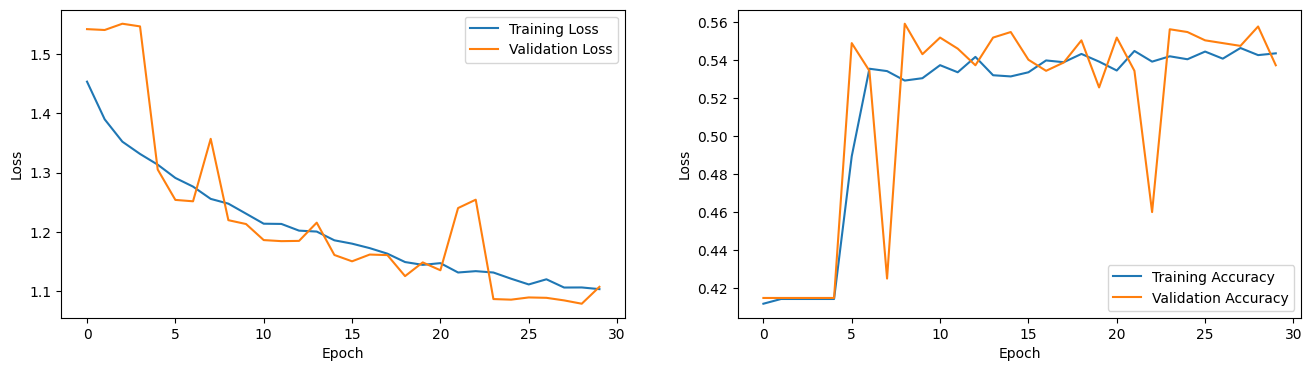

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# model = keras.models.load_model("model1.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5364 - loss: 1.1478
Test accuracy: 0.533


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
             Class   TP   FP   FN   TN
0          Dolphin    0    0  118  576
1             Fish    0    0   75  619
2       Jelly_Fish  123  281    5  285
3  

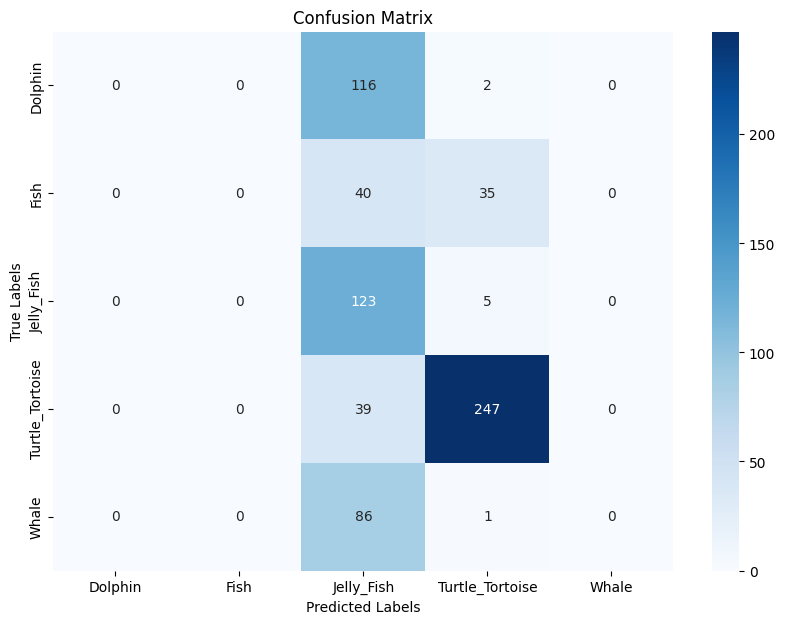

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
# Get true labels and predictions from the test dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate TP, FP, TN, FN for each class
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN
})

print(conf_matrix_df)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


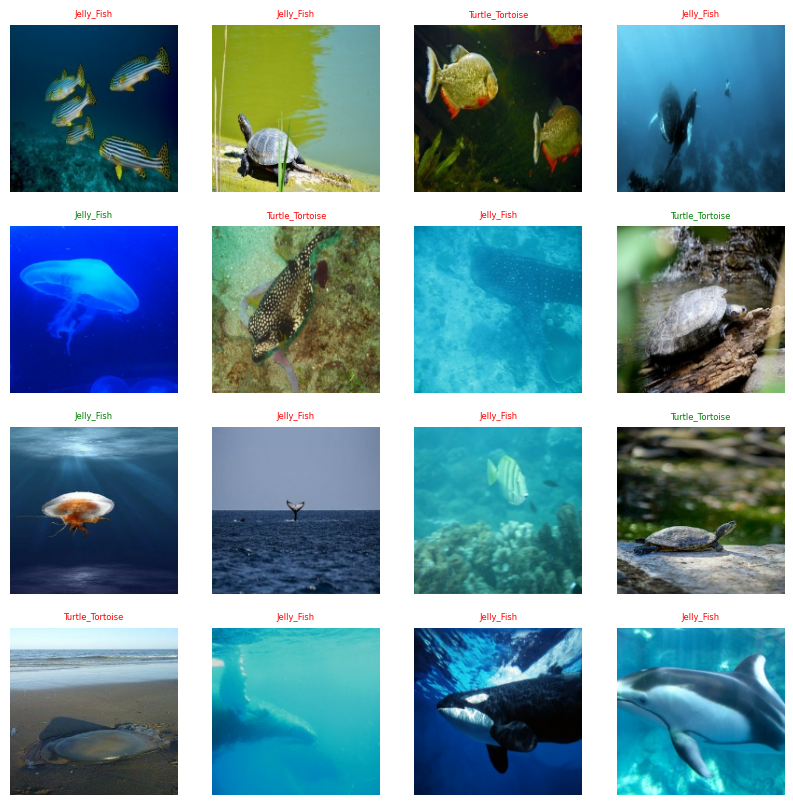

In [ ]:
#Show sample 4x4 predictions
import matplotlib.pyplot as plt
import numpy as np

# Adjust this to fit the dataset's class names
class_names = ['Dolphin', 'Fish', 'Jelly_Fish', 'Turtle_Tortoise', 'Whale']

# Take enough images and labels from the test dataset for a 16x16 grid (256 images)
images = []
labels = []
for batch_images, batch_labels in test_dataset:
    images.extend(batch_images.numpy())
    labels.extend(batch_labels.numpy())
    if len(images) >= 16:  # Collect exactly 256 images for 16x16 grid
        images = images[:16]
        labels = labels[:16]
        break

# Convert to numpy arrays for easy handling
images = np.array(images)
labels = np.array(labels)

# Make predictions
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Plotting images with predictions and actual labels in a 16x16 grid
plt.figure(figsize=(10, 10))
for i in range(16):  # 16x16 grid
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Display the image

    # Set title with actual and predicted labels
    actual_class = class_names[labels[i]]
    predicted_class = class_names[predicted_labels[i]]
    color = "green" if predicted_class == actual_class else "red"  # Green if correct, else red
    plt.title(f"{predicted_class}", color=color, fontsize=6)  # Only display predicted label for space

    plt.axis("off")

plt.show()


## Resultados primer modelo

El modelo inicial de clasificación de animales marinos no logró una precisión ideal debido a la complejidad inherente del problema. Los animales marinos presentan variabilidad en sus características visuales, tales como diferencias en iluminación, ángulos de captura, y condiciones del entorno marino, las cuales dificultan la tarea de clasificación. Además, algunas especies pueden tener características similares, lo cual agrava la posibilidad de confusión en el modelo. A pesar de utilizar una arquitectura avanzada basada en ResNet, el modelo inicial mostró dificultades en extraer características lo suficientemente profundas para diferenciar cada clase de manera robusta.

## Modelo Mejorado

Para mejorar el rendimiento, desarrollamos una versión mejorada del modelo que incorpora varias modificaciones en la arquitectura y el proceso de entrenamiento:

- `Bloques Squeeze-and-Excite (SE)`: Se añadieron bloques SE en cada capa residual, permitiendo al modelo aprender a "enfocar" selectivamente características importantes. Esto ayuda a mejorar la capacidad del modelo para diferenciar las características visuales relevantes de cada especie marina.

- `Regularización y Data Augmentation Mejorada`: La arquitectura mejorada incorpora técnicas de regularización L2 y una mayor variedad de aumentos de datos. Añadimos aleatoriedad en el brillo y el contraste, además de aumentar las rotaciones y zooms. Esto busca hacer al modelo más robusto frente a las variaciones en las imágenes.

- `Compensación de Desequilibrio en el Conjunto de Datos`: Para abordar el problema de clases desbalanceadas, calculamos y aplicamos pesos de clase que permiten asignar mayor importancia a las clases menos representadas, ayudando al modelo a aprender de manera más equilibrada.

- `Callbacks Avanzados`: Incorporamos el uso de callbacks como ReduceLROnPlateau para ajustar dinámicamente la tasa de aprendizaje y EarlyStopping para detener el entrenamiento cuando no se observen mejoras en la validación. Esto permite un ajuste más fino del modelo y previene el sobreajuste.

Class Weights: {0: 1.1755027422303475, 1: 1.863768115942029, 2: 1.0879864636209813, 3: 0.4827327327327327, 4: 1.6075}


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 90, 90, 64)     │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_281         │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_48    │ (None, 45, 45, 64)     │        74,820 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_49    │ (None, 45, 45, 64)     │        74,820 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_50    │ (None, 45, 45, 64)     │        74,820 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_51    │ (None, 23, 23, 128)    │       233,096 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_52    │ (None, 23, 23, 128)    │       298,120 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_53    │ (None, 23, 23, 128)    │       298,120 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_54    │ (None, 23, 23, 128)    │       298,120 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_55    │ (None, 12, 12, 256)    │       929,040 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_56    │ (None, 12, 12, 256)    │     1,190,160 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_57    │ (None, 12, 12, 256)    │     1,190,160 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_58    │ (None, 12, 12, 256)    │     1,190,160 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_59    │ (None, 12, 12, 256)    │     1,190,160 │
│ (ImprovedResidualSEUnit)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_residual_se_unit_60    │ (None, 12, 12, 256)    │     1,190,160 │
│ (ImprovedResidualSEUnit)        │                        │             

 Total params: 21,465,457 (81.88 MB)

 Trainable params: 21,448,433 (81.82 MB)

 Non-trainable params: 17,024 (66.50 KB)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.3805 - loss: 28.2844 - val_accuracy: 0.2664 - val_loss: 7.1017 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.4704 - loss: 5.5961 - val_accuracy: 0.2766 - val_loss: 3.5201 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.4884 - loss: 3.2628 - val_accuracy: 0.3814 - val_loss: 2.4665 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.4760 - loss: 2.5705 - val_accuracy: 0.1499 - val_loss: 2.6621 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.5080 - loss: 2.2152 - val_accuracy: 0.2504 - val_loss: 2.5604 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.4992 - loss: 2.0632 - val_accuracy: 0.6317 - val_loss: 1.5700 - learning_rate: 5.0000e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.5081 - los

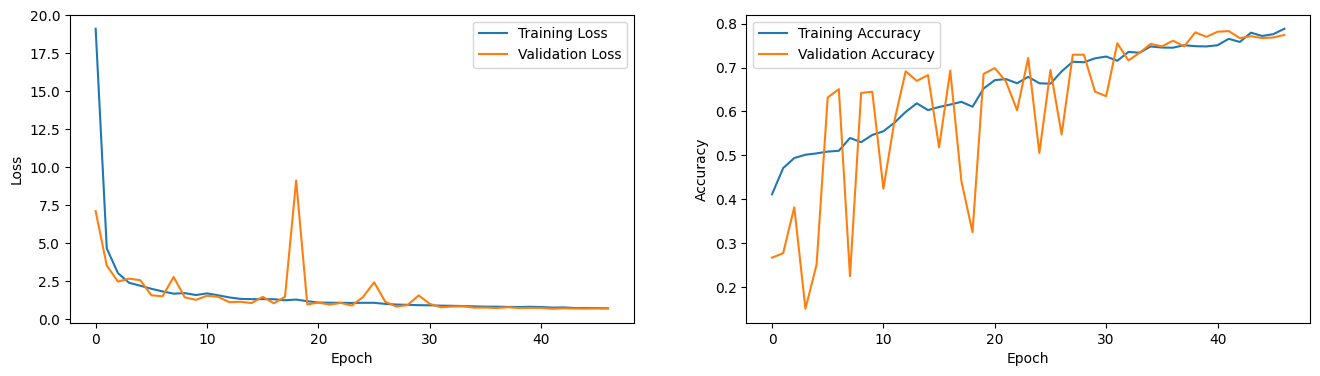

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.8096 - loss: 0.7064
Improved Test accuracy: 0.798


In [43]:
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply


# Assume 'train_dataset' yields batches of (images, labels)
all_labels = []
for images, labels in train_dataset:
    all_labels.extend(labels.numpy())  # Accumulate all labels into a list

# Convert labels to numpy array for easy computation
all_labels = np.array(all_labels)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Convert to a dictionary to use in model.fit
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)


# Define the Squeeze-and-Excite block
def squeeze_excite_block(inputs, ratio=16):
    filters = inputs.shape[-1]
    se = GlobalAveragePooling2D()(inputs)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)
    return Multiply()([inputs, se])


# Improved RSE Residual Unit Class with Squeeze-and-Excite
# Define the ImprovedResidualSEUnit with layers initialized in __init__
class ImprovedResidualSEUnit(keras.layers.Layer): 
    def __init__(self, filters, strides=1, activation="relu", ratio=16, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
        # Define main convolutional layers
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False,
                                kernel_regularizer=regularizers.l2(0.005)),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(activation),
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False,
                                kernel_regularizer=regularizers.l2(0.005)),
            keras.layers.BatchNormalization()
        ]
        
        # Define skip layers for the residual connection
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False,
                                    kernel_regularizer=regularizers.l2(0.005)),
                keras.layers.BatchNormalization()
            ]
        
        # Define Squeeze-and-Excite layers
        self.global_avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1, 1, filters))
        self.dense1 = Dense(filters // ratio, activation="relu", kernel_initializer="he_normal")
        self.dense2 = Dense(filters, activation="sigmoid", kernel_initializer="he_normal")
        
        self.ratio = ratio  # Ratio for SE block

    def squeeze_excite_block(self, inputs):
        se = self.global_avg_pool(inputs)
        se = self.reshape(se)
        se = self.dense1(se)
        se = self.dense2(se)
        return Multiply()([inputs, se])

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        
        # Apply Squeeze-and-Excite
        Z = self.squeeze_excite_block(Z)
        
        # Skip connection
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        
        return self.activation(Z + skip_Z)


# Improved ResNet Model with RSE blocks
improved_model = keras.models.Sequential()
improved_model.add(keras.layers.Input(shape=(180, 180, 3)))

# Data augmentation pipeline outside the main model
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.10),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomBrightness(0.2),
    keras.layers.Rescaling(1./255),
    keras.layers.RandomContrast(0.2)
])

# Improved ResNet Architecture with RSE
improved_model.add(data_augmentation)
improved_model.add(keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False,
                                       kernel_regularizer=regularizers.l2(0.01)))
improved_model.add(keras.layers.BatchNormalization())
improved_model.add(keras.layers.Activation("relu"))
improved_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    improved_model.add(ImprovedResidualSEUnit(filters, strides=strides))
    prev_filters = filters

improved_model.add(keras.layers.GlobalAvgPool2D())
improved_model.add(keras.layers.Dropout(0.5))
improved_model.add(keras.layers.Dense(len(class_names), activation="softmax"))

improved_model.summary()

# Compile the improved model
improved_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

# Callbacks for the improved model
improved_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="improved_resnet_ocean_animals.keras",
        save_best_only=True,
        monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5, 
        restore_best_weights=True)
]

# Training the improved model
improved_history = improved_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    class_weight=class_weights_dict,
    callbacks=improved_callbacks
)

# Plot training and validation metrics for improved model
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(improved_history.history['loss'], label='Training Loss')
plt.plot(improved_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(improved_history.history['accuracy'], label='Training Accuracy')
plt.plot(improved_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluating the improved model on the test set
test_loss, test_acc = improved_model.evaluate(test_dataset)
print(f"Improved Test accuracy: {test_acc:.3f}")


In [55]:
# Save the improved model (Squeeze-and-Excite ResNet)
improved_model.save("improved_resnet_ocean_animals.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
             Class   TP  FP  FN   TN
0          Dolphin   86  40  32  536
1             Fish   54  22  21  597
2       Jelly_Fish  111  23  17

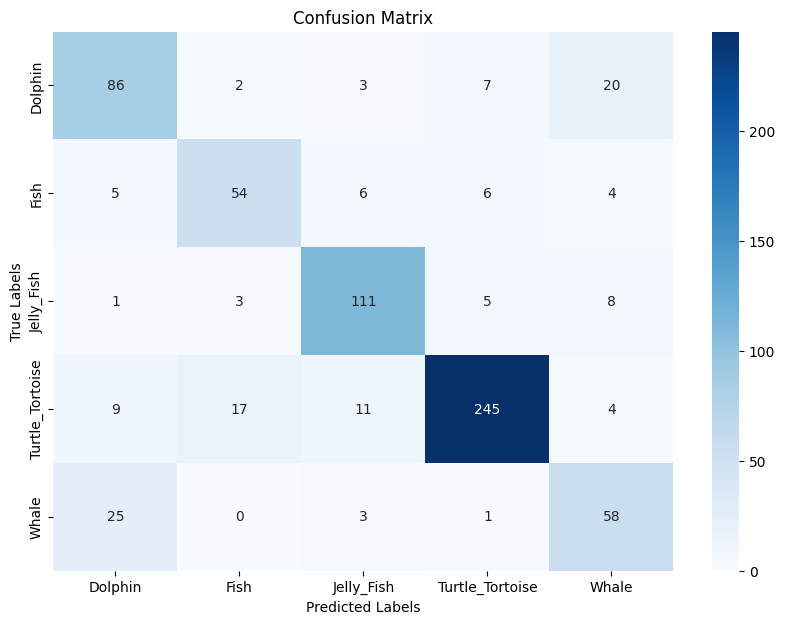

In [56]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
# Get true labels and predictions from the test dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = improved_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Assuming y_true and y_pred are the true and predicted labels respectively
cm = confusion_matrix(y_true, y_pred)

# Calculate TP, FP, TN, FN for each class
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame({
    'Class': class_names,
    'TP': TP,
    'FP': FP,
    'FN': FN,
    'TN': TN
})

print(conf_matrix_df)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


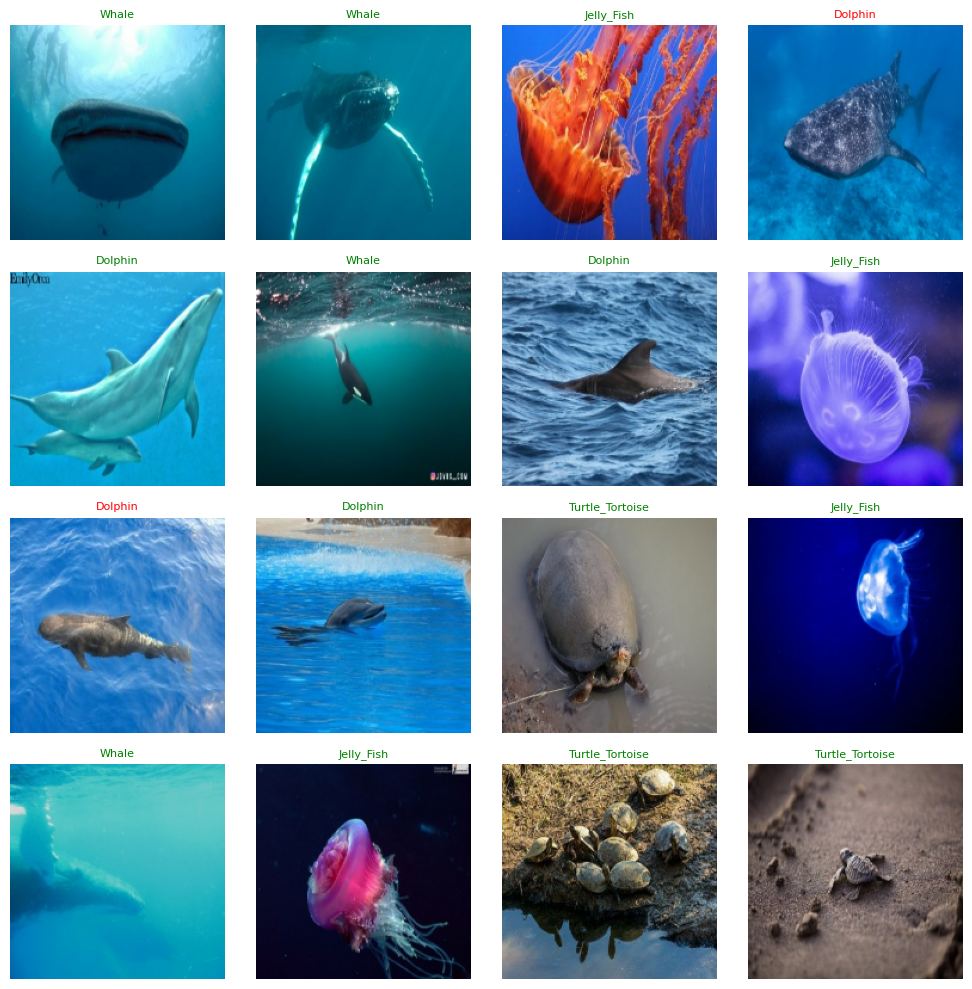

In [50]:
# Adjust this to fit the dataset's class names
class_names = ['Dolphin', 'Fish', 'Jelly_Fish', 'Turtle_Tortoise', 'Whale']

# Take enough images and labels from the test dataset for a 4x4 grid (16 images)
images = []
labels = []
for batch_images, batch_labels in test_dataset:
    images.extend(batch_images.numpy())
    labels.extend(batch_labels.numpy())
    if len(images) >= 16:  # Collect exactly 16 images for 4x4 grid
        images = images[:16]
        labels = labels[:16]
        break

# Convert to numpy arrays for easy handling
images = np.array(images)
labels = np.array(labels)

# Make predictions
predictions = improved_model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Plotting images with predictions and actual labels in a 4x4 grid
plt.figure(figsize=(10, 10))
for i in range(16):  # 4x4 grid
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Display the image

    # Set title with actual and predicted labels
    actual_class = class_names[labels[i]]
    predicted_class = class_names[predicted_labels[i]]
    color = "green" if predicted_class == actual_class else "red"  # Green if correct, else red
    plt.title(f"{predicted_class}", color=color, fontsize=8)  # Only display predicted label for space

    plt.axis("off")

plt.tight_layout()
plt.show()


## Resultados del Modelo Mejorado
Los resultados del modelo mejorado muestran un avance significativo en comparación con el modelo inicial, alcanzando una precisión de 80.96% en el conjunto de validación y un 79.8% en el conjunto de prueba. Estas métricas representan un gran aumento en la capacidad del modelo para clasificar correctamente a las especies de animales marinos, confirmando la efectividad de las mejoras implementadas.

A continuación, se presentan algunos puntos clave en los resultados:

- `Aumento en la Precisión y Reducción de la Pérdida`: La pérdida final del modelo mejorado fue de 0.7064, lo que indica una mejor comprensión de los patrones en los datos en comparación con el modelo inicial. La precisión en las predicciones sugiere que el modelo ahora puede diferenciar mejor las distintas especies marinas.

- `Análisis de la Matriz de Confusión`: La matriz de confusión muestra un aumento en los valores de Verdaderos Positivos (TP) para cada clase, especialmente en las especies más difíciles de clasificar. Por ejemplo, para la clase de las tortugas, el modelo logró 245 TP frente a solo 41 FN, lo que representa una gran mejora en la precisión y la sensibilidad de la clasificación.

- `Impacto de los Bloques Squeeze-and-Excite y la Regularización`: La incorporación de bloques Squeeze-and-Excite ha ayudado a reducir los falsos positivos (FP) y falsos negativos (FN) en varias clases. Esto es evidente en la clase de Whale, que ahora cuenta con un balance más adecuado entre sus TP, FP y FN, reflejando que el modelo puede identificar mejor las características específicas de las ballenas frente a otras especies (Dolphin)

- `Mejoras en la Robustez del Modelo`: Las técnicas de aumento de datos adicionales (como variación en el brillo y contraste) y el uso de pesos de clase equilibrados contribuyeron a que el modelo sea más robusto frente a las variaciones naturales en las imágenes de animales marinos, adaptándose mejor a distintos ambientes y características visuales.

## Mejoras

A pesar de los avances significativos logrados en este modelo, existen diversas áreas que pueden ser optimizadas para mejorar aún más el rendimiento y la capacidad del sistema de clasificación de animales marinos. Tener más imágenes con mejor calidad es algo esencial para obtener buenos resultados. Además usar modelos preentrenados mejoraría el desempeño de las clasificaciones



# Visualizar mas resultados :)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step


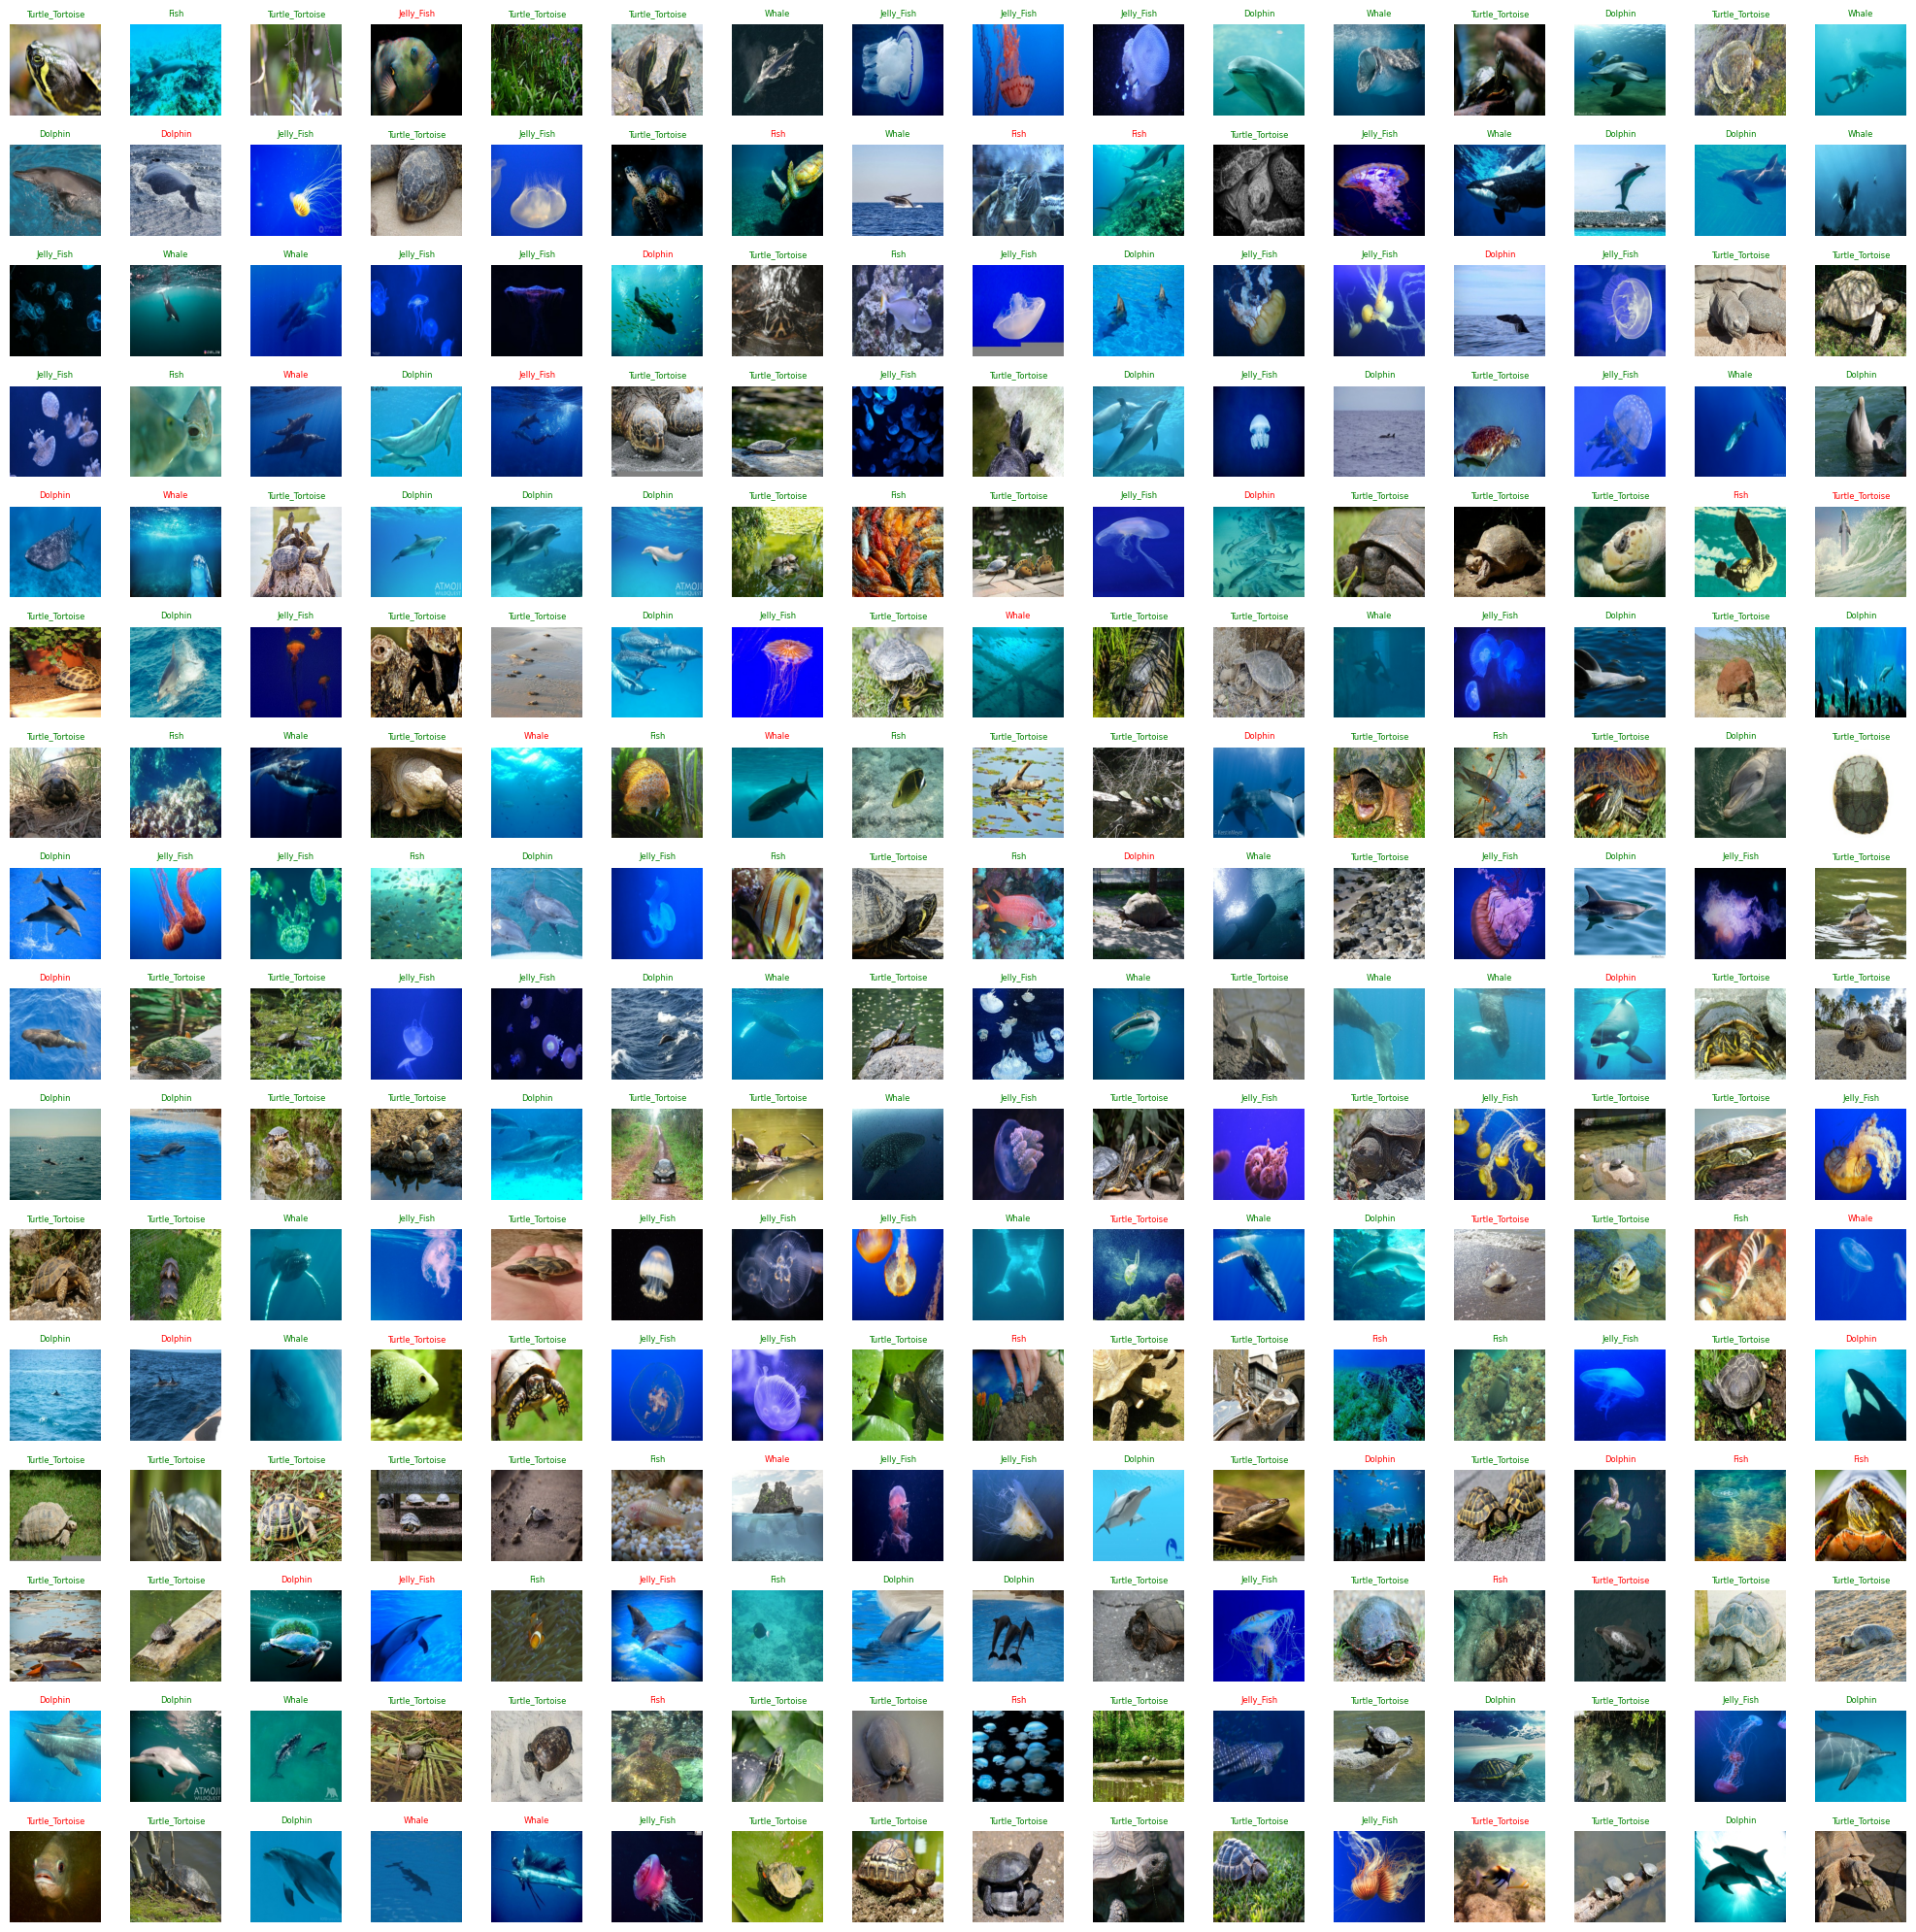

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Adjust this to fit the dataset's class names
class_names = ['Dolphin', 'Fish', 'Jelly_Fish', 'Turtle_Tortoise', 'Whale']

# Take enough images and labels from the test dataset for a 16x16 grid (256 images)
images = []
labels = []
for batch_images, batch_labels in test_dataset:
    images.extend(batch_images.numpy())
    labels.extend(batch_labels.numpy())
    if len(images) >= 256:  # Collect exactly 256 images for 16x16 grid
        images = images[:256]
        labels = labels[:256]
        break

# Convert to numpy arrays for easy handling
images = np.array(images)
labels = np.array(labels)

# Make predictions
predictions = improved_model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Plotting images with predictions and actual labels in a 16x16 grid
plt.figure(figsize=(20, 20))
for i in range(256):  # 16x16 grid
    ax = plt.subplot(16, 16, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Display the image

    # Set title with actual and predicted labels
    actual_class = class_names[labels[i]]
    predicted_class = class_names[predicted_labels[i]]
    color = "green" if predicted_class == actual_class else "red"  # Green if correct, else red
    plt.title(f"{predicted_class}", color=color, fontsize=6)  # Only display predicted label for space

    plt.axis("off")

plt.tight_layout()
plt.show()